In [1]:
import pandas as pd
import numpy as np
import os
import sys 
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid
import xgboost as xgb
from xgboost import plot_importance, plot_tree

c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: otobuf is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
abs = os.getcwd()
abs = abs.replace("\\src\\Time_series","")
sys.path.insert(0, abs   + "\\utils")

In [4]:
from time_series import split_train_test_validation
from common import process_check
from common import process_normal
from common import process_standard
from common import process_labelencode
from common import RandomizedSCV
from common import corr_mat
from common import co_mat

In [5]:
Continental_df = pd.read_csv(abs + "/dataset/Time_series/Continental_df.csv")

In [6]:
Continental_df.columns

Index(['Unnamed: 0', 'week', 'category', 'city_code', 'checkout_price',
       'base_price', 'emailer_for_promotion', 'homepage_featured',
       'num_orders', 'op_area'],
      dtype='object')

In [7]:
Continental_df.drop(columns = ['Unnamed: 0'], inplace = True)

In [8]:
Continental_df.category.unique()

array(['Beverages', 'Pizza', 'Seafood', 'Fish'], dtype=object)

In [9]:
Continental_df.city_code.unique()

array([647, 614, 679, 659, 526, 590, 599, 685, 461, 649, 541, 478, 703,
       576, 628, 702, 579, 596, 648, 632, 522, 615, 577, 517, 651, 683,
       713, 609, 675, 553, 593, 654, 693, 658, 515, 556, 561, 680, 620,
       638, 700, 676, 604, 456, 562, 695, 699, 602, 485, 698, 473],
      dtype=int64)

In [10]:
Continental_df.emailer_for_promotion.unique()

array([0, 1], dtype=int64)

In [11]:
Continental_df.homepage_featured.unique()

array([1, 0], dtype=int64)

In [12]:
df = Continental_df[['week', 'category', 'city_code', 'checkout_price', 'base_price', 'emailer_for_promotion', 'homepage_featured', 'num_orders', 'op_area']]

In [13]:
df.category, cont_category_lab = process_labelencode(df, "category", True)
df.city_code, cont_city_code_lab = process_labelencode(df, "city_code", True)

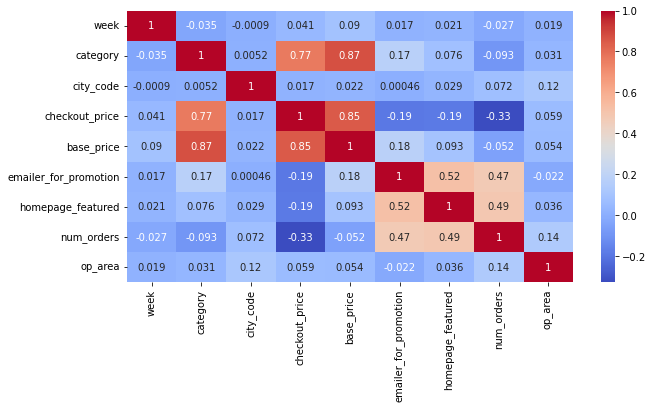

In [14]:
corr_mat(df)

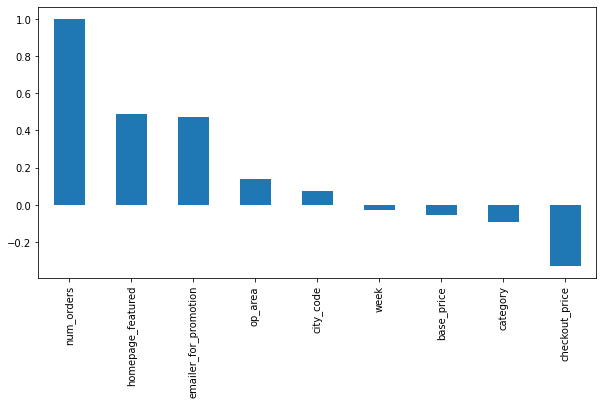

In [15]:
co_mat(df, 'num_orders')

In [16]:
df.corr()['num_orders'].abs().sort_values(ascending=False)

num_orders               1.000000
homepage_featured        0.490588
emailer_for_promotion    0.472488
checkout_price           0.328663
op_area                  0.136668
category                 0.093273
city_code                0.071877
base_price               0.052093
week                     0.026717
Name: num_orders, dtype: float64

In [17]:
sca, norm = process_check(df)
print(sca, norm)

['week', 'category', 'city_code', 'checkout_price'] ['base_price', 'emailer_for_promotion', 'homepage_featured', 'num_orders', 'op_area']


In [18]:
sca = ['week', 'checkout_price']
norm = ['base_price', 'op_area']
df[sca], stand_cont = process_standard(df, sca)
df[norm], normal_cont = process_normal(df, norm)
norm = ['num_orders']
df[norm], normal_cont_num = process_normal(df, norm)

In [19]:
X_train, y_train, X_valid, y_valid, X_test, y_test = split_train_test_validation(df, 0.2, 0.1, 'num_orders')

c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\ML_framework\utils\time_series.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = train.drop([label], 1)
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\ML_framework\utils\time_series.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_valid = valid.drop([label], 1)
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\ML_framework\utils\time_series.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_test  = test.drop([label], 1)


In [20]:
parameters = {
    'n_estimators': [350, 400],
    'learning_rate': [0.05, 0.001],
    'max_depth': [10, 11, 12],
    'gamma': [0.01, 0.1]
}

param_size = ParameterGrid(parameters)
len(param_size)

24

In [21]:
eval_set = [(X_train, y_train), (X_valid, y_valid)]
gpu_dict = {
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist',
    'eval_set': 'eval_set',
     'verbose': False,
     
}

In [22]:
%%time
model = xgb.XGBRegressor(**gpu_dict)
random_result = RandomizedSCV(model,parameters,1, -1, len(param_size)-4, X_train, y_train)

print('Best Score: ', random_result.best_score_*100)
print('Best Params: ', random_result.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[21:00:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "eval_set", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Best Score:  56.55330062924195
Best Params:  {'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.01}
CPU times: total: 4.69 s
Wall time: 8min 51s


In [23]:
%%time

model = xgb.XGBRegressor(**random_result.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: total: 1min 36s
Wall time: 12.5 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.01, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=400, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [24]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)}')
print(f'y_pred = {y_pred}')

y_true = [0.02608362 0.02109705 0.03644035 ... 0.01035673 0.01534331 0.00537016]
y_pred = [0.01263487 0.01518792 0.01518792 ... 0.04433993 0.04433993 0.04433993]


In [25]:
score = model.score(X_test,y_test)
score

0.6071371143225446

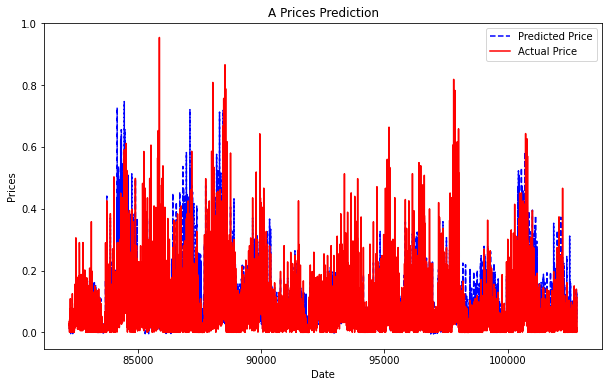

In [26]:
test_set_range = y_test.index
plt.plot(test_set_range, y_pred, color='blue', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, y_test, color='red', label='Actual Price')
plt.title('A Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

Beverages, 647, 326, 385, 0 , 1, 2

In [27]:
week = int(input("Weeks: ")) + 145
category = (input("Category: "))
city_code = int(input("City Code: "))
checkout_price = float(input("Checkout Price: "))
base_price = float(input("Base Price: "))
emailer_for_promotion = int(input("Emailer for Promotion: "))
homepage_featured = int(input("Homepage Featured: "))
op_area = float(input("Operational Area: "))

In [28]:
cat_lst = []
cat_lst.append(category)
city_code_lst = []
city_code_lst.append(city_code)

category = cont_category_lab.transform(cat_lst)
city_code = cont_city_code_lab.transform(city_code_lst)
print(category[0],city_code)
city_code[0]

0 [30]


30

In [29]:
sca = []
sca.append(week)
sca.append(checkout_price)
sca = np.reshape(sca, (-1,2 ))
sca1 = stand_cont.transform(sca)
sca1

array([[ 1.67810297, -1.37093897]])

In [30]:
nor = []
nor.append(base_price)
nor.append(op_area)
nor = np.reshape(nor, (-1,2 ))
nor1 = normal_cont.transform(nor)
nor1

array([[0.2221833 , 0.18032787]])

In [31]:
main_lst = []
main_lst.append(sca1[0][0])
main_lst.append(category[0])
main_lst.append(city_code[0])
main_lst.append(sca1[0][1])
main_lst.append(nor1[0][0])
main_lst.append(emailer_for_promotion)
main_lst.append(homepage_featured)
main_lst.append(nor1[0][1])
main_lst

[1.6781029659489985,
 0,
 30,
 -1.3709389743897102,
 0.2221832983018049,
 0,
 1,
 0.18032786885245902]

In [32]:
main_lst = np.reshape(main_lst, (-1,8 ))
pred = model.predict(main_lst)
pred = np.reshape(pred, (-1,1 ))
pred = normal_cont_num.inverse_transform(pred)
pred[0][0]

362.69205

In [33]:
pickle.dump(model, open(abs + "\\output\\Time Series\\Continental\\model.pkl", 'wb'))
pickle.dump(cont_category_lab, open(abs + "\\output\\Time Series\\Continental\\cont_category_lab.pkl", 'wb'))
pickle.dump(cont_city_code_lab, open(abs + "\\output\\Time Series\\Continental\\cont_city_code_lab.pkl", 'wb'))
pickle.dump(stand_cont, open(abs + "\\output\\Time Series\\Continental\\stand_cont.pkl", 'wb'))
pickle.dump(normal_cont, open(abs + "\\output\\Time Series\\Continental\\normal_cont.pkl", 'wb'))
pickle.dump(normal_cont_num, open(abs + "\\output\\Time Series\\Continental\\normal_cont_num.pkl", 'wb'))